<a href="https://colab.research.google.com/github/amsha16/MachineLearningTF/blob/master/6_Titanic_Survival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import tensorflow as tf
import matplotlib.pyplot as plt


Load the titanic dataset

In [0]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [0]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [0]:
tf.random.set_seed(123)

Preprocess the data

In [0]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

one-hot-encoding categorical variables

In [0]:
def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))

In [0]:
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))


Build the input pipeline (!TODO - other option)

In [0]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset
      .repeat(n_epochs)
      .batch(NUM_EXAMPLES))
    return dataset
  return input_fn

In [0]:
# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

LinearModel

In [0]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))


accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


Boosted Trees model

In [0]:
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))


accuracy                  0.818182
accuracy_baseline         0.625000
auc                       0.869177
auc_precision_recall      0.853320
average_loss              0.416570
label/mean                0.375000
loss                      0.416570
precision                 0.780220
prediction/mean           0.371572
recall                    0.717172
global_step             100.000000
dtype: float64


Preictions using Boosted Tree

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpnyyhsjk9/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


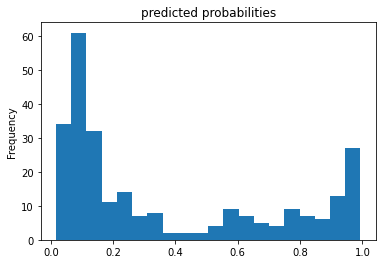

In [0]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()


ROC Curve

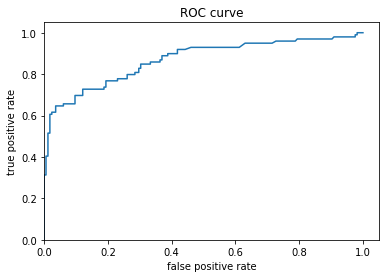

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()


###Dense NN Model TODO

In [0]:
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(9,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])


nn_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True) )
nn_model.summary()
nn_model._layers = [layer for layer in nn_model._layers if not isinstance(layer, dict)]

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 16)                144       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 34        
Total params: 178
Trainable params: 178
Non-trainable params: 0
_________________________________________________________________


In [0]:
import tempfile
model_dir = tempfile.mkdtemp()
keras_estimator = tf.keras.estimator.model_to_estimator(keras_model= nn_model)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp9ihq4rsy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# Train model.

keras_estimator.train(train_input_fn, steps =500)

# Evaluation.
result = keras_estimator.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))


INFO:tensorflow:Calling model_fn.


KeyError: ignored